In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import cv2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# dimensions of our images.
img_width, img_height = 128, 128

train_data_dir = '/content/drive/MyDrive/Defectdetection/Train_cropped'
validation_data_dir = '/content/drive/MyDrive/Defectdetection/Test_cropped'
nb_train_samples = 115
nb_validation_samples = 48
epochs = 10
batch_size = 16

In [4]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [7]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [8]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 115 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

<ipython-input-10-50dac1443f25>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
7/7 [==============================] - 51s 6s/step - loss: 0.7079 - accuracy: 0.5758 - val_loss: 0.6740 - val_accuracy: 0.5833
Epoch 2/10
7/7 [==============================] - 4s 596ms/step - loss: 0.6360 - accuracy: 0.6263 - val_loss: 0.6047 - val_accuracy: 0.5833
Epoch 3/10
7/7 [==============================] - 4s 664ms/step - loss: 0.6429 - accuracy: 0.6465 - val_loss: 0.6640 - val_accuracy: 0.4167
Epoch 4/10
7/7 [==============================] - 5s 748ms/step - loss: 0.5944 - accuracy: 0.6970 - val_loss: 1.0164 - val_accuracy: 0.5833
Epoch 5/10
7/7 [==============================] - 5s 812ms/step - loss: 0.5688 - accuracy: 0.7374 - val_loss: 0.5502 - val_accuracy: 0.7917
Epoch 6/10
7/7 [==============================] - 5s 797ms/step - loss: 0.3913 - accuracy: 0.8788 - val_loss: 0.4931 - val_accuracy: 0.6042
Epoch 7/10
7/7 [==============================] - 4s 600ms/step - loss: 0.3829 - accuracy: 0.8384 - val_loss: 0.1623 - val_accuracy: 1.0000
Epoch 8/10
7/7 [======

In [11]:
model.save('cnn_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


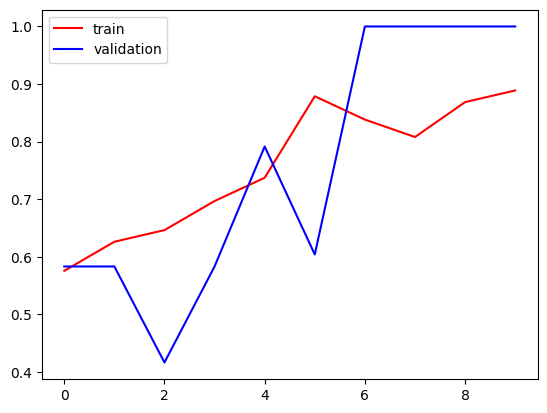

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

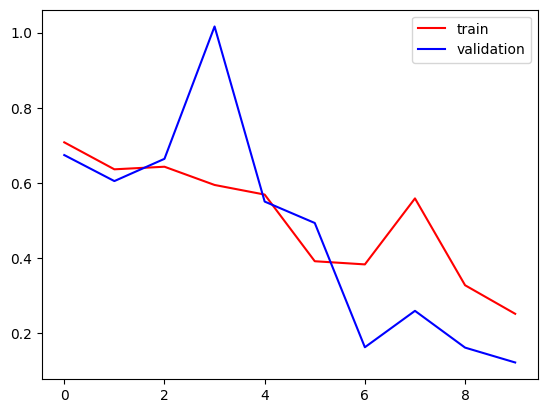

In [13]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

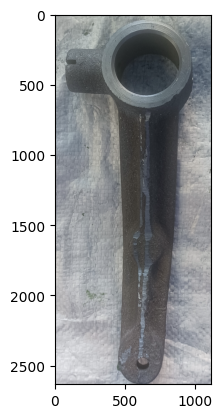

In [14]:
import cv2
test_img = cv2.imread('/content/drive/MyDrive/Defectdetection/Test_cropped/Defected/Copy of IMG_20231002_155802.jpg')
plt.imshow(test_img)


In [15]:
test_img.shape

(2633, 1113, 3)

In [16]:
test_img = cv2.resize(test_img,(128,128))

In [17]:
test_input = test_img.reshape((1,128,128,3))

In [18]:
y = model.predict(test_input)

1/1 [==============================] - 0s 255ms/step


In [19]:
if(y < 0.5):
  print("THE PART IS DEFECTED, LIGHT WILL GLOW, HENCE DISCARDED")
else:
    print(" THE PART IS UNDEFECTED, LIGHT WILL NOT GLOW, HENCE ACCEPTED")

THE PART IS DEFECTED, LIGHT WILL GLOW, HENCE DISCARDED


In [ ]:
pip install tensorflow-model-optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Load the saved model
model = keras.models.load_model('/content/cnn_model2.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model to disk
with open('optimized_model.tflite', 'wb') as f:
    f.write(tflite_quantized_model)
